# Self-Driving Car Engineer Nanodegree


## Project 2: **Advanced Lane Finding** 

The goals / steps of this project are the following:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

The above steps can can be catogorized into two parts with the following structure

1. Off-line preparation
    - Camera calibration
- On-line processing/pipeline
    - Image preprocessing
        - Un-distort an image
        - Create a binary image marking possible lane pixels
        - Apply perspective transform to "birds-eye view"
    - Lane-finding algorithm
        - Detect lane pixels and fit to find the lane boundary
        - Determine the curvature of the lane and vehicle position with respect to center
    - Visualization
        - Warp the detected lane boundaries back onto the original image
        - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position


This iPython nodebook will then be 

---

## Import Packages

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import glob
%matplotlib inline

# Part 1: Off-line Preparation

## Camera Calibration

The camera calibration step meants to find the intrinsic parameters and distortion coefficients of the camera we used. 
Because each camera is unique, and these parameters should be globally avelable for each camera, I create a class for cameras.

In [9]:
class CAMERA(object):
    """
    """
    def __init__(self):
        """
        """
        self.mtx = None
        self.dist = None
        
    def calibrate(self, image_name_list, board_size=(8,6)):
        """
        Inputs:
            - image_name_list: a list of image names
            - board_size: a touple of board size, like (8,6)
        Outputs:
            - True/False: True - finished, False - failed
        """
        objpoints = [] # 3D points in real-world coordinate
        imgpoints = [] # 2D points on 2D image plane
        
        # Prepare object points (of chessboard) in one image, like: [0,0,0], [1,0,0], [2,0,0], ..., [7,5,0]
        objp = np.zeros((board_size[0]*board_size[1], 3), np.float32)
        objp[:,:2] = np.mgrid[:board_size[0], :board_size[1]].T.reshape(-1,2) # Generate x,y coordinate and fill in the objp
        
        # Loop over images
        #--------------------------------------#
        gray = None
        for fname in image_name_list:
            # Read an image 
            img = cv2.imread(fname)
            
            # Convert the current image to grayscale
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            # Find chessboar corners
            ret, corners = cv2.findChessboardCorners(gray, board_size, None)

            # If objects are found, add object points and image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        #--------------------------------------#
                
        # Calibrate camera
        #--------------------------------------#
        if gray is None:
            return False
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        self.mtx = mtx
        self.dist = dist
        #--------------------------------------#
        return True
    
    def undistort(self, img):
        """
        Input: 
            - Original image
        Output:
            - Un-distorted image
        """
        mtx = None
        return cv2.undistort(img, self.mtx, self.dist, None, mtx)


Now we create an instance for CAMERA (called **cam_1**) and calibrate it using the chessboard images in "camera_cal/"

In [10]:
# Create the camera object instance
cam_1 = CAMERA()

# Calibrate the camera
cal_images = glob.glob("camera_cal/calibration*.jpg")
# print("type(cal_images) = %s" % str(type(cal_images)))
# print("len(cal_images) = %d" % len(cal_images))
# print("cal_images = %s" % str(cal_images))
result = cam_1.calibrate(cal_images, (9,6))
print("Calibration finished!" if result else "Calibration failed!")

Calibration finished!


Processing image file calibration1.jpg


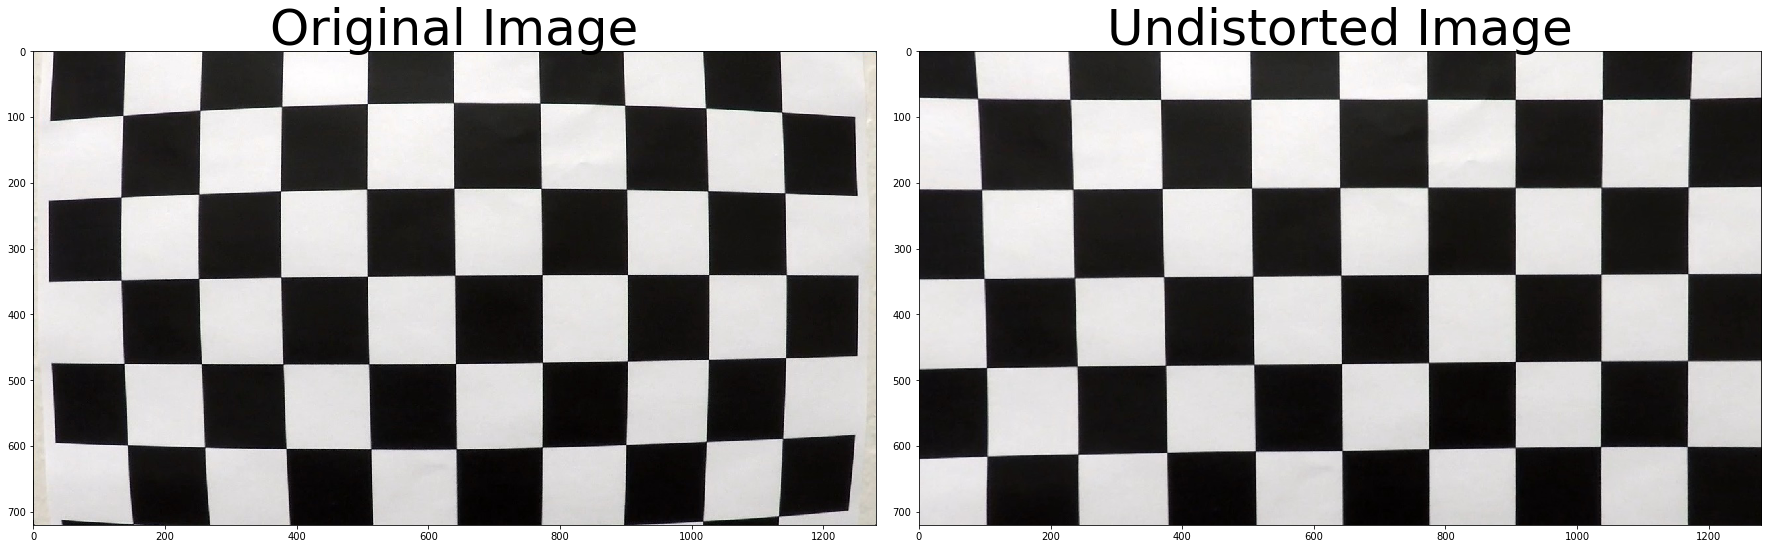

In [129]:
# Test the undistort() function
#-----------#
dir_in = "camera_cal/"
dir_out = "output_images/calibration/"
f_name = "calibration1.jpg"
print("Processing image file %s" % f_name)
img_ori = mpimg.imread(dir_in + f_name) # Read image from disk
img_undistorted = cam_1.undistort(img_ori)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_ori)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save the result figure
plt.savefig(dir_out + "undistort_result.png")

---

# Part 2: On-line Processing/Pipeline

This part describe steps that will be executed for each image on-line.

## Image preprocessing

The goal of this process is to generate a binary image which is a bird-eye viewed image marked with lane-line points according to the input image.

There are thress steps:
- Un-distort an image
- Create a binary image marking possible lane pixels
- Apply perspective transform to "birds-eye view"

---

Before we continue, I create a function to help visualizing results and save results

In [128]:
def save_image_RGB_or_gray(img, dir_out, file_name_out):
    """
    """
    # Save images using cv2.imwrite(), which require BGR color layout rather than RGB
    if len(img.shape) > 2 and img.shape[2] == 3:
        img_BGR = cv2.cvtColor( img , cv2.COLOR_RGB2BGR)
    else:
        img_BGR = img
    cv2.imwrite(dir_out + file_name_out, img_BGR)
    
def save_image_BGR_or_gray(img, dir_out, file_name_out):
    """
    """
    # Save images using cv2.imwrite(), which require BGR color layout rather than RGB
    cv2.imwrite(dir_out + file_name_out, img)
    
def functional_test_of_image(dir_in, file_name_in, dir_out, function_to_test):
    """
    The function_to_test is the following function
        img_dict = function_to_test(img)
    where img is the input image, and img_dict is an output dictionary of image
    """
    # Process one image
    #-----------#
    # Read an image
    print("Processing image file %s" % file_name_in)
    img_ori = mpimg.imread(dir_in + file_name_in) # Read image from disk

    # The function to test
    img_dict = function_to_test(img_ori) 


    # Show all the intermediate images in pipeline
    #-------------------------------------------------#
    img_dict_key= list(img_dict.keys())
    print("img_dict_key = %s" % str(img_dict_key))
    fig_id = 0
    for fig_id in range(len(img_dict_key)):
        plt.figure(fig_id)
        plt.title("Fig. %d %s" % (fig_id, str(img_dict_key[fig_id])))
        plt.imshow(img_dict[img_dict_key[fig_id]], cmap='gray')
        # Save images using cv2.imwrite(), which require BGR color layout rather than RGB
        save_image_RGB_or_gray(img_dict[img_dict_key[fig_id]], dir_out, f_name[:-4] + "_" + img_dict_key[fig_id] + ".jpg" )

Images in the "test_images" directory

In [125]:
sorted(os.listdir("test_images/"))

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

Since there is a set of parameters shared with every input images, I create classes separately for each step.

### Step 1: Un-distort the input Image

This step is done by using the CAMERA.undistort() function, which is already implemented above.

### Step 2: Getting Binary Image of Lane-lines


In [103]:
class LANE_LINE_MASK(object):
    """
    """
    def __init__(self, camera_in):
        """
        """

### Step 3: Warping Image to "Bird-eye View"

(720, 1280, 3)


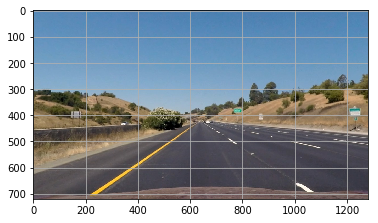

In [134]:
# Draw and save an un-distorted image with grid and poly-lines, so we can find out anchor points by eyes

# Read an image
dir_in = "test_images/"
dir_out = "output_images/warp/"
files = sorted(os.listdir(dir_in))

# Read an image
f_name = files[0] # 0 and 1
img_ori = mpimg.imread(dir_in + f_name) # Read image from disk
img_undistorted = cam_1.undistort(img_ori)
# The shape of image
img_shape = img_undistorted.shape
print(img_shape)

# Ploting
plt.imshow(img_undistorted, cmap='gray')
plt.grid()

# Save the resulted figure
plt.savefig(dir_out + f_name[:-4] + "_grid.png")

In [334]:
class IMAGE_WARPER(object):
    """
    """
    def __init__(self):
        """
        """
        # Parameters
        #-------------------------#
        img_size = (1280, 720) # (width, height)
        # Define 4 source/destination points np.float32([[,],[,],[,],[,]])
        ori_x1 = 200
        ori_x2 = img_size[0] - ori_x1
        self.warp_src = np.float32([ [593,450],[686,450],[ori_x2, img_size[1] ],[ori_x1,img_size[1] ] ])
        tranx_x1 = 350
        trans_x2 = img_size[0] - tranx_x1
        self.warp_dst = np.float32([[tranx_x1,0],[trans_x2,0],[trans_x2, img_size[1]],[tranx_x1, img_size[1]]])
        #-------------------------#
        
        # Variables
        #-------------------------#
        self.M_birdeye = None
        self.M_inv_birdeye = None
        #-------------------------#
        
        # Preparation
        self.cal_transform_matrices()
        
    def cal_transform_matrices(self):
        """
        """
        # Calculate the transform matrix
        self.M_birdeye = cv2.getPerspectiveTransform(self.warp_src, self.warp_dst)
        self.M_inv_birdeye = cv2.getPerspectiveTransform(self.warp_dst, self.warp_src)        
        
        
    def transform(self, img):
        """
        """
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, self.M_birdeye, img_size, flags=cv2.INTER_LINEAR)
    
    def inverse_transform(self, img):
        """
        """
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, self.M_inv_birdeye, img_size, flags=cv2.INTER_LINEAR)

In [335]:
# Create an instance
birdeye_trans = IMAGE_WARPER()

Test the warpping

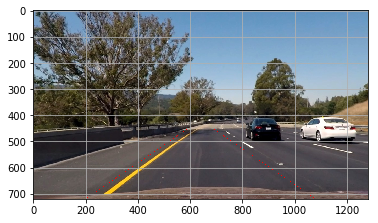

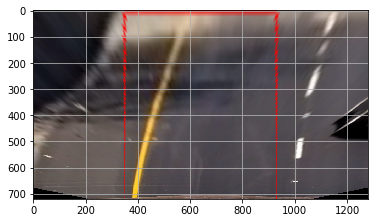

In [343]:
# Read an image
dir_in = "test_images/"
dir_out = "output_images/warp/"
files = sorted(os.listdir(dir_in))

# Read an image
f_name = files[7] # 0 and 1
img_ori = mpimg.imread(dir_in + f_name) # Read image from disk
img_undistorted = cam_1.undistort(img_ori)


img_line = np.copy(img_undistorted)
cv2.polylines(img_line, np.int32([birdeye_trans.warp_src]), isClosed=True, color=(255, 0, 0), thickness=1)
img_birdeye = birdeye_trans.transform(img_line)

# Save results
save_image_RGB_or_gray(img_line, dir_out, f_name[:-4] + "img_line.jpg")
save_image_RGB_or_gray(img_birdeye, dir_out, f_name[:-4] + "img_birdeye.jpg")



fig_id = 0
# Ploting
plt.figure(fig_id); fig_id += 1
plt.imshow(img_line, cmap='gray')
plt.grid()
# Save the resulted figure
plt.savefig(dir_out + "plot_" +  f_name[:-4] + "_line.png")

# Ploting
plt.figure(fig_id); fig_id += 1
plt.imshow(img_birdeye, cmap='gray')
plt.grid()
# Save the resulted figure
plt.savefig(dir_out + "plot_" + f_name[:-4] + "_birdeye.png")

### Integration: Combining all as IMAGE_PREPROCESSING

In [315]:
class IMAGE_PREPROCESSING(object):
    """
    """
    def __init__(self, camera_in, image_warper_in):
        """
        """
        # Parameters
        #-------------------------#
        #-------------------------#
        
        # Variables
        #-------------------------#
        self.camera = camera_in
        self.image_warper = image_warper_in
        #-------------------------#
        
        # Preparation 
    
    
    def pipeline(self, img_ori, debug=False):
        """
        """
        
        # 1. Undistort the input image
        img_undistorted = self.camera.undistort(img_ori)
        
        # 2. Create binary image marked with lane lines
        
        # 3. Convert to bird-eye view
        img_birdeye = self.image_warper.transform(img_undistorted)
        
        # Output image
        img_out = img_birdeye
        
        # Prepare a container for saving intermediate images for debugging
        img_dict = dict()
        if debug:
            img_dict["img_ori"] = img_ori
            img_dict["img_undistorted"] = img_undistorted
            img_dict["img_birdeye"] = img_birdeye
            img_dict["img_out"] = img_out
        
        return img_out, img_dict

In [108]:
# Create an instance of IMAGE_PREPROCESSING
img_preproc = IMAGE_PREPROCESSING(cam_1, birdeye_trans)

---

Now test the pipeline

In [117]:
sorted(os.listdir("test_images/"))

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

Processing image file test2.jpg
img_dict_key = ['img_ori', 'img_undistorted', 'img_birdeye', 'img_out']


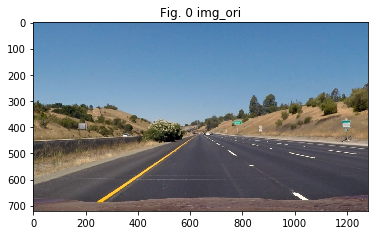

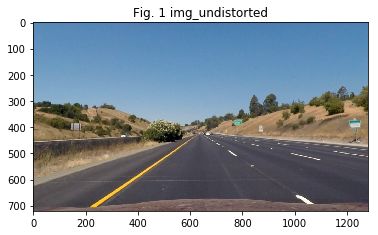

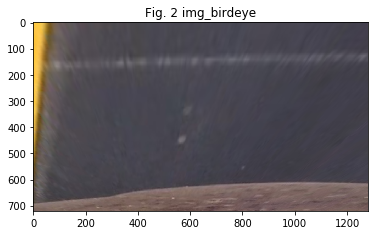

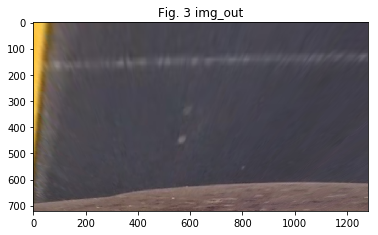

In [127]:
# Test the preprocessing
def function_to_test(img):
    img_out, img_dict = img_preproc.pipeline(img_ori, debug=True)
    return img_dict

# Process one image
#-----------#
dir_in = "test_images/"
dir_out = "output_images/image_preprocessing/"
files = sorted(os.listdir(dir_in))
# Read an image
f_name = files[3] # 5
functional_test_of_image(dir_in, f_name, dir_out, function_to_test)


In [345]:
!tar chvfz output_images.tar.gz ./output_images

./output_images/
./output_images/calibration/
./output_images/calibration/undistort_result.png
./output_images/warp/
./output_images/warp/test1img_birdeye.jpg
./output_images/warp/plot_test2_birdeye.png
./output_images/warp/plot_straight_lines1_line.png
./output_images/warp/plot_test6_birdeye.png
./output_images/warp/plot_test4_birdeye.png
./output_images/warp/plot_test5_line.png
./output_images/warp/test3img_birdeye.jpg
./output_images/warp/plot_test1_birdeye.png
./output_images/warp/test3img_line.jpg
./output_images/warp/plot_test2_line.png
./output_images/warp/test2img_line.jpg
./output_images/warp/plot_test6_line.png
./output_images/warp/plot_test3_line.png
./output_images/warp/straight_lines1img_line.jpg
./output_images/warp/straight_lines1img_birdeye.jpg
./output_images/warp/plot_straight_lines1_birdeye.png
./output_images/warp/straight_lines2img_line.jpg
./output_images/warp/straight_lines2img_birdeye.jpg
./output_images/warp/test6img_line.jpg
./output_images/warp/plot_straight_

In [ ]:
# !tar chvfz output_videos.tar.gz ./output_videos